<img src = "../assets/Screenshot 2025-04-12 133013.png"/>

First Image 

In [ ]:
from langgraph.graph import Graph, StateGraph, END
from IPython.display import Image, display
from langchain_groq import ChatGroq
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os  
from dotenv import load_dotenv 
load_dotenv()

# RAG
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

In [2]:
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")

In [3]:
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [4]:
def function1(input):
    return input + ", a substitue shinigami"

def function2(input):
    return input + " from Earth"

In [5]:
workflow1 = Graph()

In [6]:
workflow1.add_node("function1", function1)

In [7]:
workflow1.add_node("function2", function2)

In [8]:
workflow1.add_edge("function1","function2")

In [9]:
workflow1.set_entry_point("function1")

In [10]:
workflow1.set_finish_point("function2")

In [11]:
app1 = workflow1.compile()

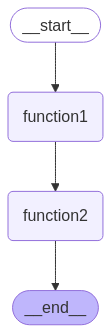

In [12]:
try:
    display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [13]:
app1.invoke("Hi, i am DP")

'Hi, i am DP, a substitue shinigami from Earth'

In [14]:
for output in app1.stream("Hi, I am DP"):
    for key, value in output.items():
        print("---------------------")
        print(f"Here is the output from {key}")
        print("======================")
        print(value)
        print()

---------------------
Here is the output from function1
Hi, I am DP, a substitue shinigami

---------------------
Here is the output from function2
Hi, I am DP, a substitue shinigami from Earth



Second Image

In [15]:
def function1(input):
    llm = ChatGroq(model_name="Gemma2-9b-It")
    return llm.invoke(input).content

In [16]:
def function2(input):
    return input.upper()

In [17]:
workflow2 = Graph()

In [18]:
workflow2.add_node("LLM", function1)

In [19]:
workflow2.add_node("upper_string", function2)

In [20]:
workflow2.add_edge("LLM","upper_string")

In [21]:
workflow2.set_entry_point("LLM")

In [22]:
workflow2.set_finish_point("upper_string")

In [23]:
app2 = workflow2.compile()

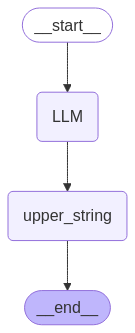

In [24]:
try:
    display(Image(app2.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [25]:
for output in app2.stream("Hi, I am DP"):
    for key, value in output.items():
        print("---------------------")
        print(f"Here is the output from {key}")
        print("======================")
        print(value)
        print()

---------------------
Here is the output from LLM
Hello DP, it's nice to meet you! What can I do for you today? 😊  



---------------------
Here is the output from upper_string
HELLO DP, IT'S NICE TO MEET YOU! WHAT CAN I DO FOR YOU TODAY? 😊  





Third one

In [26]:
def function3(input):
    token = input.split()
    token_number = len(token)
    token_number = f"Total numbers of tokens: {token_number}"
    return token_number

In [27]:
workflow3 = Graph()
workflow3.add_node("LLM", function1)
workflow3.add_node("token_counter", function3)
workflow3.add_edge("LLM","token_counter")
workflow3.set_entry_point("LLM")
workflow3.set_finish_point("token_counter")
app3 = workflow3.compile()

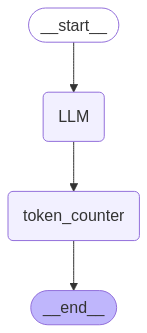

In [28]:
try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [29]:
for output in app3.stream("Hi, I am DP"):
    for key, value in output.items():
        print("---------------------")
        print(f"Here is the output from {key}")
        print("======================")
        print(value)

---------------------
Here is the output from LLM
Hello DP! 👋  Nice to meet you. What can I do for you today? 😊  


---------------------
Here is the output from token_counter
Total numbers of tokens: 15


Integrating a RAG pipeline in langgraph

In [30]:
embeddings  = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
llm = ChatGroq(model="gemma2-9b-it")

In [31]:
llm.invoke("hi")

AIMessage(content='Hello! 👋 How can I help you today? 😄\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 11, 'total_tokens': 25, 'completion_time': 0.025454545, 'prompt_time': 0.001899517, 'queue_time': 0.23237865100000002, 'total_time': 0.027354062}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-c16699e9-27ab-4ec2-a602-7214c84cd627-0', usage_metadata={'input_tokens': 11, 'output_tokens': 14, 'total_tokens': 25})

In [32]:
loader1 = DirectoryLoader('../data1', glob="./*.txt", loader_cls=TextLoader)
docs1 = loader1.load()
text_splitter1 = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50
)
new_docs1 = text_splitter1.split_documents(documents=docs1)
dB1 = Chroma.from_documents(new_docs1,embeddings)
retriever1 = dB1.as_retriever(search_kwargs = {"k" : 3})

In [33]:
query1 = "what is meta llama3?"
docs1 = retriever1.get_relevant_documents(query1)

C:\Users\Dhruv\AppData\Local\Temp\ipykernel_23600\3290084923.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs1 = retriever1.get_relevant_documents(query1)


In [34]:
print(docs1[0].metadata)
print(docs1[0].page_content)

{'source': '..\\data1\\llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in


In [35]:
for doc in docs1:
    print(doc)

page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '..\\data1\\llama3.txt'}
page_content='by Meta AI starting in February 2023.[2][3] The latest version is Llama 3 released in April' metadata={'source': '..\\data1\\llama3.txt'}
page_content='Llama 2, Meta AI started releasing instruction fine-tuned versions alongside foundation models.[7]' metadata={'source': '..\\data1\\llama3.txt'}


In [36]:
# assign AgentState as an empty dict
AgentState = {}

# messages key will be assigned as an empty array. We will append new messages as we pass along nodes. 
AgentState["messages"] = []

In [37]:
def function_1(AgentState):
    messages = AgentState['messages']
    question = messages[-1]
    complete_prompt = """Your task is to provide only the brief answer based on the user query.
    Don't include too much reasoning. Following is the query:  """ + question
    response = llm.invoke(complete_prompt)
    AgentState['messages'].append(response.content)
    # print("============")
    # print(AgentState)
    # print("-------------")
    return AgentState

In [38]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] # fetching original user question
    template = """Answer the question based on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    retrieval_chain = (
        {"context" : retriever1, "question" : RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    # print("============")
    # print(AgentState)
    # print("-------------")
    result = retrieval_chain.invoke(question)
    return result

In [39]:
# define a langchain graph
workflow4 = Graph()
workflow4.add_node("LLM", function_1)
workflow4.add_node("RAG", function_2)
workflow4.add_edge("LLM","RAG")
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAG")
app4 = workflow4.compile()

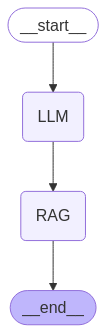

In [40]:
try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [41]:
inputs = {"messages" : ["Tell me about llama3 model"] }

In [42]:
app4.invoke(inputs)

'Based on the provided text snippets, here\'s what we know about the Llama 3 model:\n\n* **Parameter Size:** There\'s a version with 8 billion parameters (8B).\n* **Capabilities:** The 8B parameter version is described as "surprisingly capable" despite its relatively smaller size compared to other large language models.\n* **Comparisons:** Llama models have been favorably compared to other large language models, including models like Claude. \n* **Benchmark Performance:** In most benchmarks, Llama models perform well against competitors.\n\n**To get a more complete picture of Llama 3, you\'d need to consult the full document from which these snippets are taken.** \n\n\nLet me know if you have any other questions! \n'

In [43]:
for output in app4.stream(inputs):
    for key, value in output.items():
        print("------------------------------")
        print(f"Here is the output from {key}")
        print("==============================")
        print(value)

------------------------------
Here is the output from LLM
{'messages': ['Tell me about llama3 model', 'Llama 3 is an open-source large language model (LLM) developed by Meta AI.  It comes in various sizes and is known for its strong performance in various tasks like text generation, translation, and question answering. \n', 'Llama 3 is an open-source LLM by Meta AI. \n']}
------------------------------
Here is the output from RAG
Llama 3 is a large language model that has been praised for its capabilities, especially considering its size. 

Here's what we know from the provided text:

* **There's an 8B parameter version:** This refers to the size of the model, with "8B" likely standing for 8 billion parameters.
* **It's "surprisingly capable":**  This suggests that despite its relatively smaller size compared to some other large language models, Llama 3 performs well.
* **It's been compared favorably:**  Llama 3 has been benchmarked against other models like GPT and Claude, and genera

LAST ONE

In [44]:
loader2 = DirectoryLoader('../data2', glob="./*.txt", loader_cls=TextLoader)
docs2 = loader2.load()
text_splitter2 = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 50
)
new_docs2 = text_splitter2.split_documents(documents=docs2)
dB2 = Chroma.from_documents(new_docs2,embeddings)
retriever2 = dB2.as_retriever(search_kwargs = {"k" : 3})

In [45]:
query2 = "Tell me about Japan's industrial growth."
docs2 = retriever1.get_relevant_documents(query2)

In [46]:
print(docs2[0].metadata)
print(docs2[0].page_content)
for doc in docs2:
    print(doc)

{'source': '..\\data2\\japan.txt'}
Japan's last four year GDP:
page_content='Japan's last four year GDP:' metadata={'source': '..\\data2\\japan.txt'}
page_content='Industrial revival hope for Japan' metadata={'source': '..\\data2\\japan.txt'}
page_content='a recovery from the three quarters of contraction seen from April 2004 on. The Nikkei 225 index' metadata={'source': '..\\data2\\japan.txt'}


1. TypedDict is a special type that allows you to define a dictionary in python where each key has a specific type its useful when you want to enforce type checks on the keys and values of a dictionary.

2. Annotated is used to add metadata or constraints to a type. Its typically used for adding additional information, like constraints or description, to the type.

3. Sequence is a generic type from Python's typing module that represents a list-like structure (such as a list or tuple) where the order matters, and you can access elements by their position.

4. BaseMessage: This assumes you're working with the LangChain framework, and BaseMessage is part of its core messaging system. It is typically used when handling or processing messages in LangChain's workflows.

5. operator.add is a function from Python's operator module that performs addition (+) on its arguments. In this context, it is being used as metadata for the Annotated type, likely suggesting that the sequence of BaseMessage objects is concatenated with another sequence at some point. It’s an indicator of how the messages field will be treated in the program.

- TopicSelectionParser: A Pydantic model that defines two fields (Topic and Reasoning), both of which are required.

- Field: Adds metadata, like descriptions, and can also be used for validation and constraints.

- Pydantic's Role: Ensures that the data matches the expected structure and types, raising validation errors if they do not.

In [47]:
class AgentState(TypedDict):
    # the 'message' field should be a sequence of strings, we annotate it with operator.add
    # this implies that we might want to "add" new messages to the sequence later
    message : Annotated[Sequence[BaseMessage], operator.add]

Putting It All Together:

- The line messages: Annotated[Sequence[BaseMessage], operator.add] defines a field messages that: Must be a sequence (like a list or tuple) of BaseMessage objects. Has the additional annotation operator.add, which suggests that this sequence is intended to support addition (i.e., concatenation of multiple sequences of messages).

eg. "messages": [BaseMessage("Hello!", "Alice"), BaseMessage("Hi!", "Bob")]

In [48]:
class TopicSelectionParser(BaseModel):
    Topic : str = Field(description="Selected Topic")
    Reasoning : str = Field(description="Reasoning behind the topic selection")

In [49]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [50]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind the topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [51]:
def function__1(state):
    message = state['message']
    question = message[-1]
    template = """
    Your task is to classify the given user query into one of the following categories : [Japan, Not related].
    Only respond with the category name and nothing else.

    user query: {question}
    {format_instructions}
    """
    prompt = PromptTemplate(
        template=template,
        input_variables=[question],
        partial_variables={
            "format_instructions" : parser.get_format_instructions()
        }
    )
    chain = prompt | llm | parser
    response = chain.invoke({"question" : question, "format_instructions" : parser.get_format_instructions()})
    print(response)
    return {"message" : [response.Topic]}

In [52]:
state = {"message" : ["Tell me about Japan's Industrial Growth"]}

In [53]:
function__1(state)

Topic='Japan' Reasoning="The query directly asks for information about Japan's industrial growth."


{'message': ['Japan']}

In [54]:
def router(state):
    print('Router -> ')
    message = state['message']
    last_message = message[-1]
    print(last_message)
    if 'Japan' in last_message:
        return 'RAG CALL'
    return 'LLM CALL'

In [55]:
def function__2(state):
    print('-> calling RAG ->')
    message = state['message']
    question = message[0] # fetching original user question
    print(question)
    template = """Answer the question based on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    print(prompt)
    retrieval_chain = (
        {"context" : retriever1, "question" : RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    # print("============")
    # print(AgentState)
    # print("-------------")
    result = retrieval_chain.invoke(question)
    return {"message" : [result]}

In [65]:
def function__3(state):
    print('-> calling LLM ->')
    message = state['message']
    question = message[0]
    complete_prompt = """Your task is to provide only the brief answer based on the user query.
    Don't include too much reasoning. Following is the query:  """ + question
    response = llm.invoke(complete_prompt)
    # print("============")
    # print(AgentState)
    # print("-------------")
    return {"message" : [response.content]}

In [66]:
AgentState

__main__.AgentState

In [67]:
workflow5 = StateGraph(AgentState)
workflow5.add_node("agent", function__1)
workflow5.add_node("RAG", function__2)
workflow5.add_node("LLM", function__3)
workflow5.set_entry_point("agent")
workflow5.add_conditional_edges(
    "agent",
    router,
    {
        "RAG CALL" : "RAG",
        "LLM CALL" : "LLM"
    }
)
workflow5.add_edge("RAG",END)
workflow5.add_edge("LLM",END)
app5 = workflow5.compile()

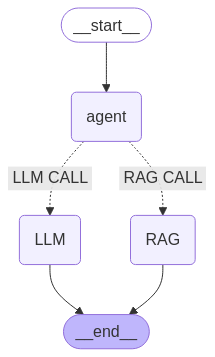

In [68]:
try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [69]:
input = {"message" : ["Tell me about Japan's Industrial Growth."]}

In [70]:
output = app5.invoke(input)

Topic='Japan' Reasoning="The query specifically asks about Japan's Industrial Growth."
Router -> 
Japan
-> calling RAG ->
Tell me about Japan's Industrial Growth.
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


In [71]:
output

{'message': ["Tell me about Japan's Industrial Growth.",
  'Japan',
  'The provided text suggests that there is hope for industrial revival in Japan. \n\nIt mentions a "recovery from the three quarters of contraction seen from April 2004 on," implying that Japan\'s industrial sector had been struggling prior to this period.  \n\nHowever, the text doesn\'t provide specific details about the nature or extent of the industrial growth. \n\n']}

In [72]:
input = {"message" : ["Tell me about Taj Mahal."] }

In [73]:
output = app5.invoke(input)

Topic='Not related' Reasoning='The Taj Mahal is in India, not Japan.'
Router -> 
Not related
-> calling LLM ->


In [74]:
output

{'message': ['Tell me about Taj Mahal.',
  'Not related',
  'The Taj Mahal is a white marble mausoleum in Agra, India.  It was built by Mughal emperor Shah Jahan in memory of his third wife Mumtaz Mahal.  \n']}